In [109]:
# imporation des librairies
import pandas as pd
import sqlite3
from datetime import date, datetime as dt

import dateutil.parser

from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
import numpy as np

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [87]:
# connection à la BDD
conn = sqlite3.connect("database/e-commerce.db")
cur = conn.cursor()

In [88]:
# récupération des dates pour la Recence pour chaque client unique
sql_recence = """ SELECT c.unique_id, o.purchase_timestamp  
                FROM order_dataset o
                JOIN customer c ON c.id = o.customer_id               
                GROUP BY unique_id 
                """

recence = cur.execute(sql_recence).fetchall()

In [89]:
# récupération des scores (votes) pour chaque client unique
sql_score = """ SELECT c.unique_id, r.score
                FROM order_review r
                JOIN order_dataset o ON o.order_id = r.order_id 
                JOIN customer c ON c.id = o.customer_id                          
                GROUP BY unique_id 
                ORDER BY r.score DESC """

score = cur.execute(sql_score).fetchall()

In [90]:
# récupération total commande pour chaque client unique
sql_nb_order = """ SELECT c.unique_id, COUNT(o.order_id) AS nb_commande 
                FROM order_dataset o
                JOIN customer c ON c.id = o.customer_id               
                GROUP BY unique_id 
                ORDER BY nb_commande DESC"""

nb_order = cur.execute(sql_nb_order).fetchall()

In [91]:
# récupération des achats totatux pour chaque client unique
sql_montant = """ SELECT SUM(p.value) as total, c.unique_id 
                FROM order_paiement p
                JOIN order_dataset o ON o.order_id = p.order_id 
                JOIN customer c ON c.id = o.customer_id                          
                GROUP BY unique_id 
                ORDER BY total DESC
                """
montant = cur.execute(sql_montant).fetchall()

In [150]:
# transformation des listes en dataframe
df_montant = pd.DataFrame(montant)
df_score = pd.DataFrame(score)
df_nb_order = pd.DataFrame(nb_order)
df_recence = pd.DataFrame(recence)

# on renomme les colonnes de chaque dataframe
df_score.columns= ["unique_id_customer",'score']
df_nb_order.columns= ["unique_id_customer",'nb_order']
df_montant.columns = ["total_buy","unique_id_customer"]
df_recence.columns = ["unique_id_customer", "order_date"]

# nombre de jour de la dernière commande à aujourd'hui
today = date.today()
df_recence["order_date"] = pd.to_datetime(df_recence["order_date"])
df_recence["last_date"] = pd.to_datetime(today)
df_recence["nb_day"] = (df_recence["last_date"] - df_recence["order_date"]).dt.days
print(df_recence)

#fusion des dataframes
df_cluster = pd.merge(df_montant,df_score)
df_cluster = df_cluster.merge(df_nb_order, how = "inner")
df_cluster = df_cluster.merge(df_recence, how = "inner")
df_cluster['nb_order'] = df_cluster['nb_order'].fillna(0)
df_cluster['score'] = df_cluster['score'].fillna(0)
df_cluster = df_cluster[["nb_order","total_buy","score", "nb_day"]]
df_cluster


                     unique_id_customer          order_date  last_date  nb_day
0      0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27 2022-12-07    1671
1      0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27 2022-12-07    1674
2      0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03 2022-12-07    2097
3      0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41 2022-12-07    1881
4      0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42 2022-12-07    1848
...                                 ...                 ...        ...     ...
96091  fffcf5a5ff07b0908bd4e2dbc735a684 2017-06-08 21:00:36 2022-12-07    2007
96092  fffea47cd6d3cc0a88bd621562a9d061 2017-12-10 20:07:56 2022-12-07    1822
96093  ffff371b4d645b6ecea244b27531430a 2017-02-07 15:49:16 2022-12-07    2128
96094  ffff5962728ec6157033ef9805bacc48 2018-05-02 15:17:41 2022-12-07    1679
96095  ffffd2657e2aad2907e67c3e9daecbeb 2017-05-02 20:18:45 2022-12-07    2044

[96096 rows x 4 columns]


,nb_order,total_buy,score,nb_day
0,1,13664.08,1,1894
1,3,9553.02,1,1582
2,2,7571.63,5,2075
3,1,7274.88,1,1605
4,1,6929.31,5,2123
...,...,...,...,...
95374,1,10.89,3,1629
95375,1,10.07,5,1910
95376,1,9.59,5,1564
95377,1,0.00,3,1555


In [151]:
# mise à l’échelle des données
scaled_df = StandardScaler().fit_transform(df_cluster)
scaled_df

array([[-0.16270931, 58.62822434, -2.28955803,  0.61005769],
       [ 9.14127832, 40.77157865, -2.28955803, -1.42049685],
       [ 4.4892845 , 32.16528753,  0.67909709,  1.78803965],
       ...,
       [-0.16270931, -0.68090517,  0.67909709, -1.53764423],
       [-0.16270931, -0.72255994, -0.80523047, -1.59621792],
       [-0.16270931, -0.72255994, -2.28955803, -1.55716879]])

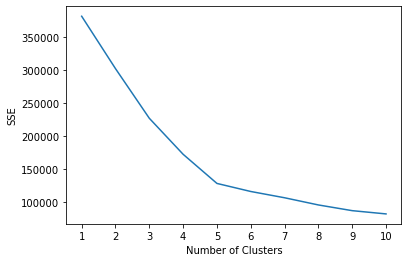

In [152]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [154]:
kmeans = KMeans(init="random", n_clusters=5, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(scaled_df)

#view cluster assignments for each observation
kmeans.labels_

df_cluster['cluster'] = kmeans.labels_

#view updated DataFrame
df_cluster

,nb_order,total_buy,score,nb_day,cluster
0,1,13664.08,1,1894,4
1,3,9553.02,1,1582,4
2,2,7571.63,5,2075,4
3,1,7274.88,1,1605,4
4,1,6929.31,5,2123,4
...,...,...,...,...,...
95374,1,10.89,3,1629,1
95375,1,10.07,5,1910,3
95376,1,9.59,5,1564,1
95377,1,0.00,3,1555,1


In [155]:
# moyenne des achats
moyenne_buy = df_cluster.groupby(["cluster"])["total_buy"].mean().reset_index()
moyenne_buy


,cluster,total_buy
0,0,289.512073
1,1,133.245624
2,2,152.371941
3,3,134.509996
4,4,1276.850328


In [156]:
# moyenne du nombre de commande
moyenne_purchase = df_cluster.groupby(["cluster"])["nb_order"].mean().reset_index()
moyenne_purchase

,cluster,nb_order
0,0,2.11687
1,1,1.00000
2,2,1.00000
3,3,1.00000
4,4,1.01909


In [157]:
# moyenne des étoiles
moyenne_score = df_cluster.groupby(["cluster"])["score"].mean().reset_index()
moyenne_score

,cluster,score
0,0,4.122967
1,1,4.669580
2,2,1.591678
3,3,4.631644
4,4,3.954968


In [158]:
# répartition des clusters en nombre et pourcentage
nb_clients = df_cluster.groupby(["cluster"])['score'].count().reset_index()
nb_clients.columns = ['cluster', 'count']
nb_clients['percent'] = (100*nb_clients['count']) / nb_clients['count'].sum()

nb_clients

,cluster,count,percent
0,0,2952,3.095021
1,1,41992,44.026463
2,2,16727,17.537403
3,3,31665,33.199132
4,4,2043,2.141981


In [167]:
# moyenne des nombres de jour des dernières commandes
moyenne_days = df_cluster.groupby(["cluster"])["nb_day"].mean().reset_index()
moyenne_days

,cluster,nb_day
0,0,1693.034252
1,1,1805.467346
2,2,1812.201561
3,3,1953.351314


In [169]:
df_graph = pd.merge(moyenne_score,moyenne_purchase).merge(moyenne_buy).merge(nb_clients).merge(moyenne_days)
#df_graph = pd.merge(df_graph,moyenne_buy)
df_graph

,cluster,score,nb_order,total_buy,count,percent,nb_day
0,0,4.122967,2.11687,289.512073,2952,3.095021,1693.034252
1,1,4.669580,1.00000,133.245624,41992,44.026463,1805.467346
2,2,1.591678,1.00000,152.371941,16727,17.537403,1812.201561
3,3,4.631644,1.00000,134.509996,31665,33.199132,1953.351314


In [160]:
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
source = nb_clients

alt.Chart(source).mark_arc().encode(
    theta=alt.Theta(field="count", type="quantitative"),
    color=alt.Color(field="cluster", type="nominal"),
)

alt.Chart(...)

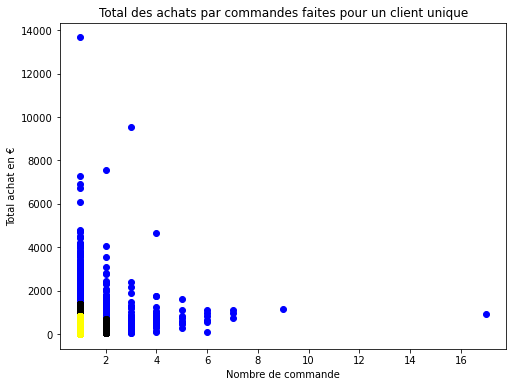

In [174]:
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
n_clusters = 5
gmm_model = GaussianMixture(n_components=n_clusters)
gmm_model.fit(df_cluster)

plt.figure(figsize=(8,6))

cluster_labels = gmm_model.predict(df_cluster)
X = df_cluster
X['cluster'] = cluster_labels
color = np.array(['Red','green','blue', 'Black', 'yellow'])

for k in range(0,n_clusters):
    data = X[X["cluster"]==k]
    plt.scatter(data["nb_order"],data["total_buy"],c=color[k])


plt.title("Total des achats par commandes faites pour un client unique")    
plt.ylabel("Total achat en €")
plt.xlabel("Nombre de commande")
plt.show()

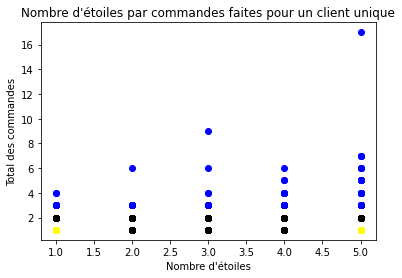

In [175]:
for k in range(0,n_clusters):
    data = X[X["cluster"]==k]
    plt.scatter(data["score"],data["nb_order"],c=color[k])


plt.title("Nombre d'étoiles par commandes faites pour un client unique")    
plt.ylabel("Total des commandes")
plt.xlabel("Nombre d'étoiles")
plt.show()

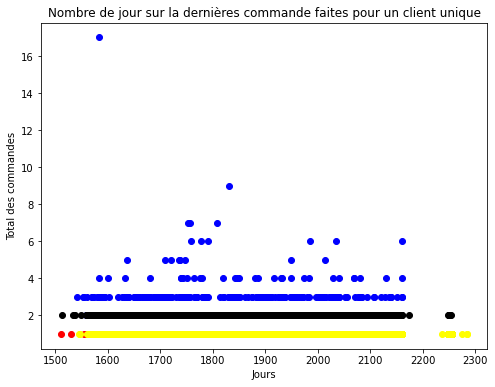

In [178]:
plt.figure(figsize=(8,6))
for k in range(0,n_clusters):
    data = X[X["cluster"]==k]
    plt.scatter(data["nb_day"],data["nb_order"],c=color[k])


plt.title("Nombre de jour sur la dernières commande faites pour un client unique")    
plt.ylabel("Total des commandes")
plt.xlabel("Jours")
plt.show()